In [ ]:
# Sentence Segmentation

# The first step in building a knowledge graph is to split the text document or article into sentences.

In [5]:
import stanza
stanza.download('en') # download the model first


nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize')
# doc = nlp('This is a test sentence for stanza. This is another sentence.')

2021-11-03 21:05:23 INFO: Downloading default packages for language: en (English)...


2021-11-03 21:06:45 INFO: Finished downloading models and saved to /Users/cinder/stanza_resources.
2021-11-03 21:06:45 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2021-11-03 21:06:45 INFO: Use device: cpu
2021-11-03 21:06:45 INFO: Loading: tokenize
2021-11-03 21:06:45 INFO: Done loading processors!


In [29]:
# doc.sentences[1]

In [21]:
with open('/Users/cinder/Desktop/FYP/preprocessed_cases/16/case0.txt') as f:
    text = f.read()

In [23]:
case_01 = nlp_stanza(text)

In [36]:
case_01.sentences[0].text

'petitioner directv,and its customers entered into a service agreement that included a binding arbitration provision with a waiver.'

In [42]:
## another library to trail

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp_spacy = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [44]:
# candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
# candidate_sentences.shape

In [47]:
len(case_01.sentences)

180

In [43]:
doc_01 = nlp_spacy(case_01.sentences[0].text)

for tok in doc_01:
  print(tok.text, "...", tok.dep_)

petitioner ... compound
directv ... ROOT
, ... punct
and ... cc
its ... poss
customers ... nsubj
entered ... conj
into ... prep
a ... det
service ... compound
agreement ... pobj
that ... nsubj
included ... relcl
a ... det
binding ... amod
arbitration ... compound
provision ... dobj
with ... prep
a ... det
waiver ... pobj
. ... punct


In [48]:
candidate_sentences =[]
for i in range(len(case_01.sentences)):
    candidate_sentences.append(case_01.sentences[i].text)

In [54]:
candidate_sentences[0]

'petitioner directv,and its customers entered into a service agreement that included a binding arbitration provision with a waiver.'

In [41]:
# Entity Pairs Extraction
# The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.

In [45]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp_spacy(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [55]:
entity_pairs = []

for i in tqdm(candidate_sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 180/180 [00:01<00:00, 141.56it/s]


In [56]:
entity_pairs

[['service that', 'binding arbitration waiver'],
 ['waivers', 'state'],
 ['waivers', 'superior  court'],
 ['however mobility llc california', 'federal arbitration act'],
 ['california court', 'appeal'],
 ['entire arbitration provision', 'agreement'],
 ['california it', 'california law'],
 ['ambiguous  that', 'drafter'],
 ['california it', 'california law'],
 ['federal arbitration court', 'arbitration agreement'],
 ['california it', 'california law'],
 ['ordinarily state court', 'volt information leland'],
 ['correct california it', 'federal arbitration act'],
 ['california buckeye courts', 'other arbitration contracts'],
 ['several  considerations', 'conclusion'],
 ['first phrase law', 'valid state law'],
 ['general contract references', 'how doe it'],
 ['general subject that', 'federal state law'],
 ['court', 'only  arbitration'],
 ['one  courts', 'other  contexts'],
 ['other california courts', 'same  interpretation'],
 ['invalid antidrafter canon', 'similar california arbitration'],

In [ ]:
# Relation / Predicate Extraction

# Our hypothesis is that the predicate is actually the main verb in a sentence.

In [79]:
def get_relation(sent):

  doc = nlp_spacy(sent)

  # Matcher class object 
  matcher = Matcher(nlp_spacy.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [75]:
# test = nlp_spacy(candidate_sentences[0])

In [76]:
# matcher = Matcher(nlp_spacy.vocab)

In [77]:
# pattern = [{'DEP':'ROOT'}, 
#         {'DEP':'prep','OP':"?"},
#         {'DEP':'agent','OP':"?"},  
#         {'POS':'ADJ','OP':"?"}] 

In [78]:
# matcher.add("matching_1", [pattern]) 

In [85]:
# get_relation(candidate_sentences[1])

In [84]:
# candidate_sentences[1]

In [86]:
relations = [get_relation(i) for i in tqdm(candidate_sentences)]

100%|██████████| 180/180 [00:01<00:00, 152.22it/s]


In [87]:
pd.Series(relations).value_counts()[:50]

is                     15
see                    12
held                    4
provides                3
denied                  3
reasoned                3
thought                 3
filed                   2
answer                  2
seek                    2
asked                   2
recognize               2
reversed                2
decide                  2
choose                  2
said                    2
drafted                 2
delivered               2
states                  2
applied                 2
appears                 2
held in                 2
denies                  2
place                   2
clarifies               2
chose                   2
dissenting              1
ordered                 1
began as                1
take                    1
describe california     1
have                    1
read                    1
reads                   1
adopts                  1
contains                1
construed               1
reach                   1
become routi

In [ ]:
# Build a Knowledge Graph
''' We will finally create a knowledge graph from the extracted entities (subject-object pairs)
    and the predicates (relation between entities).'''

In [88]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [89]:
# create a directed-graph from a dataframe
# we will use the networkx library to create a network from this dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

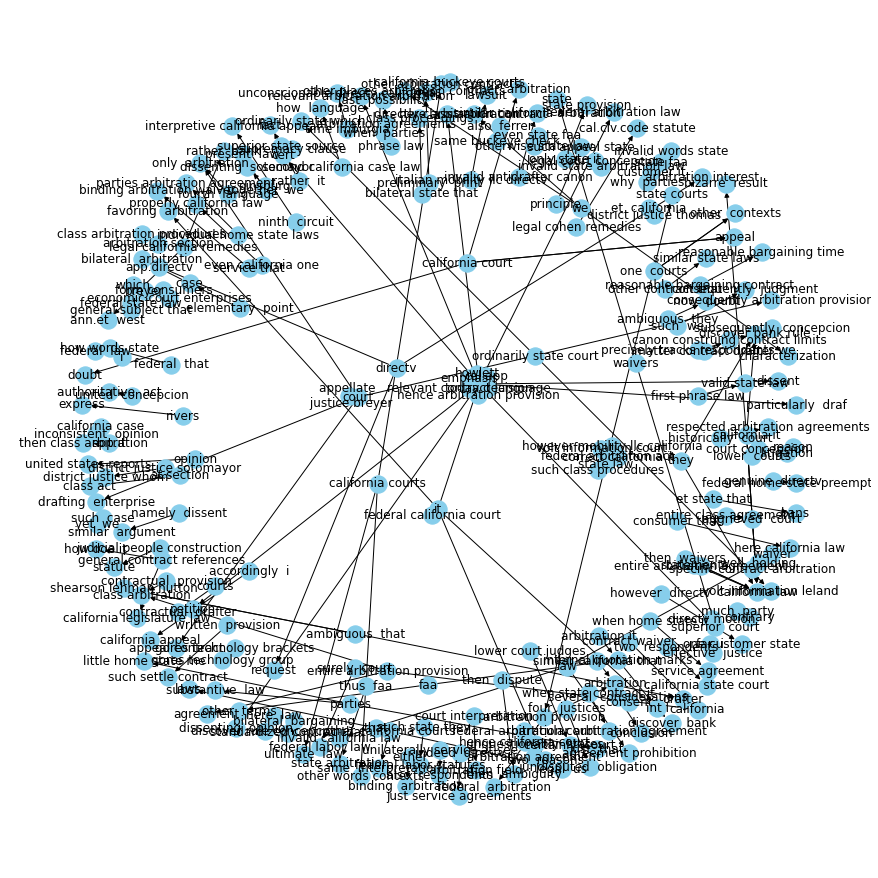

In [90]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

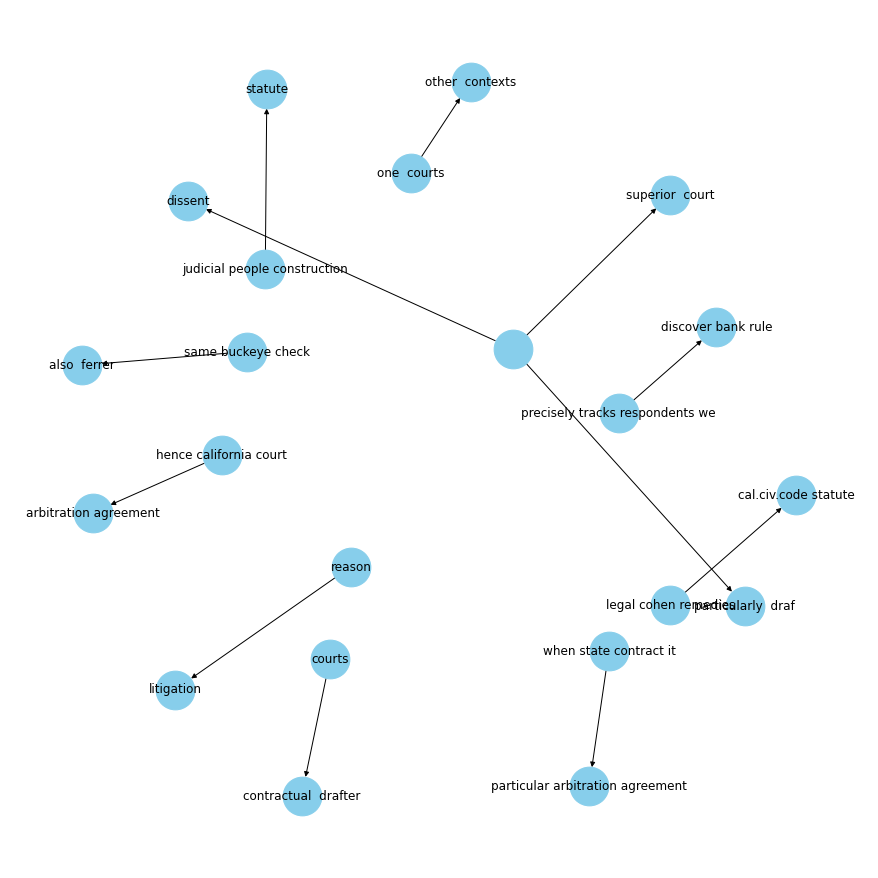

In [99]:

'''it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. 
    Let’s start with the relation “see” '''

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="see"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()